# Conversative regridding

In [1]:
%reload_ext autoreload

%autoreload 2

import os
import tempfile

import cdo
import iris
import iris.coord_systems
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

from ml_downscaling_emulator.utils import cp_model_rotated_pole, platecarree

In [2]:
xwind_cpm_path = '../../scratch/xwind.nc'
ywind_cpm_path = '../../scratch/ywind.nc'
xwind_cpm_with_bnds_path = "../../scratch/xwind-bnds.nc"
xwind_cpm_gcmed_path = "../../scratch/xwind-gcmed.nc"

gcm_target_grid_path = '../../scratch/moose_grid.nc'
gcm_target_grid_with_bnds_path = '../../scratch/moose_grid-bnds.nc'

In [3]:
ds_cpm = xr.open_mfdataset([xwind_cpm_path, ywind_cpm_path])
target_wo_bnds_ds = xr.open_dataset(gcm_target_grid_path)

In [4]:
lat_bnds = np.copy(ds_cpm["grid_latitude_bnds"].values)
lat_bnds[-1][1] = 8.962849
ds_cpm["grid_latitude_bnds"].values = lat_bnds
ds_cpm["grid_latitude_bnds"].values

array([[-5.582749, -5.546749],
       [-5.546749, -5.510749],
       [-5.510749, -5.474749],
       ...,
       [ 8.854849,  8.890849],
       [ 8.890849,  8.926849],
       [ 8.926849,  8.962849]], dtype=float32)

### CDO conversative remap

In [6]:
input_file = tempfile.NamedTemporaryFile(delete=True, prefix='cdo_xr_input_', dir=tempfile.gettempdir())
print(input_file.name)
ds_cpm.to_netcdf(input_file.name)

ds_gcmed = cdo.Cdo().remapcon(gcm_target_grid_with_bnds_path, input=input_file.name, returnXDataset = True)
ds_gcmed

/tmp/cdo_xr_input_yo8cu4x_


<xarray.Dataset>
Dimensions:             (time: 30, bnds: 2, longitude: 432, latitude: 324,
                         pressure: 2)
Coordinates:
  * time                (time) object 1980-12-01 12:00:00 ... 1980-12-30 12:0...
  * longitude           (longitude) float32 -179.6 -178.8 -177.9 ... 178.8 179.6
  * latitude            (latitude) float32 -89.72 -89.17 -88.61 ... 89.17 89.72
  * pressure            (pressure) float32 20.0 850.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) object ...
    leadtime            (time) timedelta64[ns] ...
    longitude_bnds      (longitude, bnds) float32 ...
    latitude_bnds       (latitude, bnds) float32 ...
    latitude_longitude  int32 ...
    x_wind              (time, pressure, latitude, longitude) float32 ...
    y_wind              (time, pressure, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    source:       Data from Met Office Unified Model
    um_version:   10.6
    history:      Wed Jul 13 15:37:31 2022: cdo -O -s -f nc -remapcon,../../s...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

### Iris linear and NN regrid

In [7]:
target_lat_name = 'latitude'
target_lon_name = 'longitude'
target_coord_sys = iris.coord_systems.GeogCS(6371229.0)
src_lat_name = 'grid_latitude'
src_lon_name = 'grid_longitude'
src_coord_sys = iris.coord_systems.RotatedGeogCS(37.5, 177.5, ellipsoid=target_coord_sys)

In [8]:
target_cube = iris.load_cube(gcm_target_grid_path)
# target_cube.coord("time").bounds = cftime.date2num(target_ds["time_bnds"].values, target_ds["time_bnds"].encoding["units"])
target_cube.coord(target_lon_name).guess_bounds()
target_cube.coord(target_lat_name).guess_bounds()
iris.save(target_cube, gcm_target_grid_with_bnds_path)
target_cube = iris.load_cube(gcm_target_grid_with_bnds_path)
target_ds = xr.open_dataset(gcm_target_grid_with_bnds_path)

In [9]:
xwind_src_cube = ds_cpm['x_wind'].to_iris()
xwind_src_cube.coord(src_lon_name).coord_system = src_coord_sys
xwind_src_cube.coord(src_lat_name).coord_system = src_coord_sys
xwind_src_cube.coord(src_lon_name).bounds = ds_cpm[f"{src_lon_name}_bnds"].values
xwind_src_cube.coord(src_lat_name).bounds = ds_cpm[f"{src_lat_name}_bnds"].values
# xwind_src_cube.coord(src_lon_name).bounds = xwind_cpm[f"{src_lon_name}_bnds"].values
# xwind_src_cube.coord(src_lat_name).bounds = xwind_cpm[f"{src_lat_name}_bnds"].values
# iris.save(xwind_src_cube, xwind_cpm_with_bnds_path)

In [28]:
gcm_lin_regridder = iris.analysis.Linear(extrapolation_mode="mask").regridder(xwind_src_cube, target_cube)
xwind_lin_gcmed_cube = gcm_lin_regridder(xwind_src_cube)
xwind_lin_gcmed_da = xr.DataArray.from_iris(xwind_lin_gcmed_cube)

gcm_nn_regridder = iris.analysis.Nearest(extrapolation_mode="mask").regridder(xwind_src_cube, target_cube)
xwind_nn_gcmed_cube = gcm_nn_regridder(xwind_src_cube)
xwind_nn_gcmed_da = xr.DataArray.from_iris(xwind_nn_gcmed_cube)

### Re-grid back to CPM grid

In [34]:
ds_gcmed

<xarray.Dataset>
Dimensions:             (time: 30, bnds: 2, longitude: 432, latitude: 324,
                         pressure: 2)
Coordinates:
  * time                (time) object 1980-12-01 12:00:00 ... 1980-12-30 12:0...
  * longitude           (longitude) float32 -179.6 -178.8 -177.9 ... 178.8 179.6
  * latitude            (latitude) float32 -89.72 -89.17 -88.61 ... 89.17 89.72
  * pressure            (pressure) float32 20.0 850.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) object 1980-12-01 00:00:00 ... 1981-01-0...
    leadtime            (time) timedelta64[ns] 450 days 12:00:00 ... 479 days...
    longitude_bnds      (longitude, bnds) float32 -180.0 -179.2 ... 179.2 180.0
    latitude_bnds       (latitude, bnds) float32 -90.0 -89.44 ... 89.44 90.0
    latitude_longitude  int32 1
    x_wind              (time, pressure, latitude, longitude) float32 nan ......
    y_wind              (time, pressure, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    source:       Data from Met Office Unified Model
    um_version:   10.6
    history:      Wed Jul 13 15:37:31 2022: cdo -O -s -f nc -remapcon,../../s...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [36]:
xwind_lin_gcmed_da

<xarray.DataArray 'x_wind' (time: 30, pressure: 2, latitude: 324, longitude: 432)>
dask.array<filled, shape=(30, 2, 324, 432), dtype=float32, chunksize=(30, 2, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 ... 1980-12-30...
  * pressure                 (pressure) float32 20.0 850.0
  * latitude                 (latitude) float32 -89.72 -89.17 ... 89.17 89.72
  * longitude                (longitude) float32 -179.6 -178.8 ... 178.8 179.6
    forecast_reference_time  object ...
    realization              int64 ...
    forecast_period          (time) timedelta64[ns] ...
Attributes:
    standard_name:    x_wind
    units:            m s-1
    um_stash_source:  m01s30i201
    cell_methods:     time: mean (interval: 1 hour)

In [37]:
target_ds

<xarray.Dataset>
Dimensions:                  (time: 2, latitude: 324, longitude: 432, bnds: 2)
Coordinates:
  * time                     (time) object 1980-12-01 12:00:00 1980-12-02 12:...
  * latitude                 (latitude) float32 -89.72 -89.17 ... 89.17 89.72
  * longitude                (longitude) float32 -179.6 -178.8 ... 178.8 179.6
    forecast_period          (time) timedelta64[ns] ...
    forecast_reference_time  object ...
    realization              int32 ...
Dimensions without coordinates: bnds
Data variables:
    precipitation_flux       (time, latitude, longitude) float32 ...
    latitude_longitude       int32 ...
    time_bnds                (time, bnds) object ...
    latitude_bnds            (latitude, bnds) float32 ...
    longitude_bnds           (longitude, bnds) float32 ...
    forecast_period_bnds     (time, bnds) float64 ...
Attributes:
    source:       Data from Met Office Unified Model
    um_version:   10.4
    Conventions:  CF-1.7

In [40]:
xwind_gcmed_cube = ds_gcmed["x_wind"].to_iris()
xwind_gcmed_cube.coord("projection_x_coordinate").coord_system = target_coord_sys
xwind_gcmed_cube.coord("projection_y_coordinate").coord_system = target_coord_sys
cpm_regridder = iris.analysis.Nearest().regridder(target_cube, xwind_src_cube)

In [43]:
xwind_gcmed_cpmed = xr.DataArray.from_iris(cpm_regridder(xwind_gcmed_cube))

ValueError: The given cube is not defined on the same source grid as this regridder.

In [44]:
xwind_gcmed_cpmed = xr.DataArray.from_iris(iris.analysis.Nearest().regridder(xwind_gcmed_cube, xwind_src_cube)(xwind_gcmed_cube))

xwind_lin_gcmed_cpmed_da = xr.DataArray.from_iris(cpm_regridder(xwind_lin_gcmed_cube))
xwind_nn_gcmed_cpmed_da = xr.DataArray.from_iris(cpm_regridder(xwind_nn_gcmed_cube))

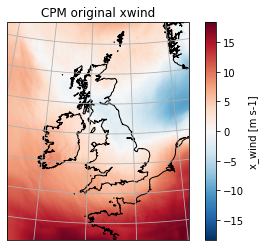

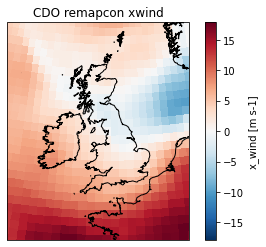

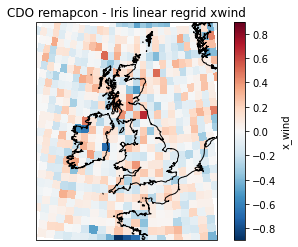

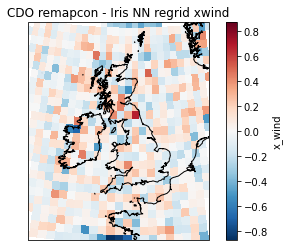

In [52]:
ax = plt.axes(projection=cp_model_rotated_pole)

ds_cpm["x_wind"].isel(time=0, pressure=1).plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
# ax.set_extent([-6, 5, -5, 8])
ax.gridlines()
ax.set_title("CPM original xwind")
ax.coastlines()

plt.show()

ax = plt.axes(projection=cp_model_rotated_pole)

xwind_gcmed_cpmed.isel(time=0, pressure=1).plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
# ax.set_extent([-6, 5, -5, 8])
ax.set_title("CDO remapcon xwind")
ax.coastlines()

plt.show()

ax = plt.axes(projection=cp_model_rotated_pole)

(xwind_gcmed_cpmed-xwind_lin_gcmed_cpmed_da).isel(time=0, pressure=1).plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
# ax.set_extent([-6, 5, -5, 8])
ax.set_title("CDO remapcon - Iris linear regrid xwind")
ax.coastlines()

plt.show()

ax = plt.axes(projection=cp_model_rotated_pole)

(xwind_gcmed_cpmed-xwind_nn_gcmed_cpmed_da).isel(time=0, pressure=1).plot(ax=ax, x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
# ax.set_extent([-6, 5, -5, 8])
ax.set_title("CDO remapcon - Iris NN regrid xwind")
ax.coastlines()

plt.show()

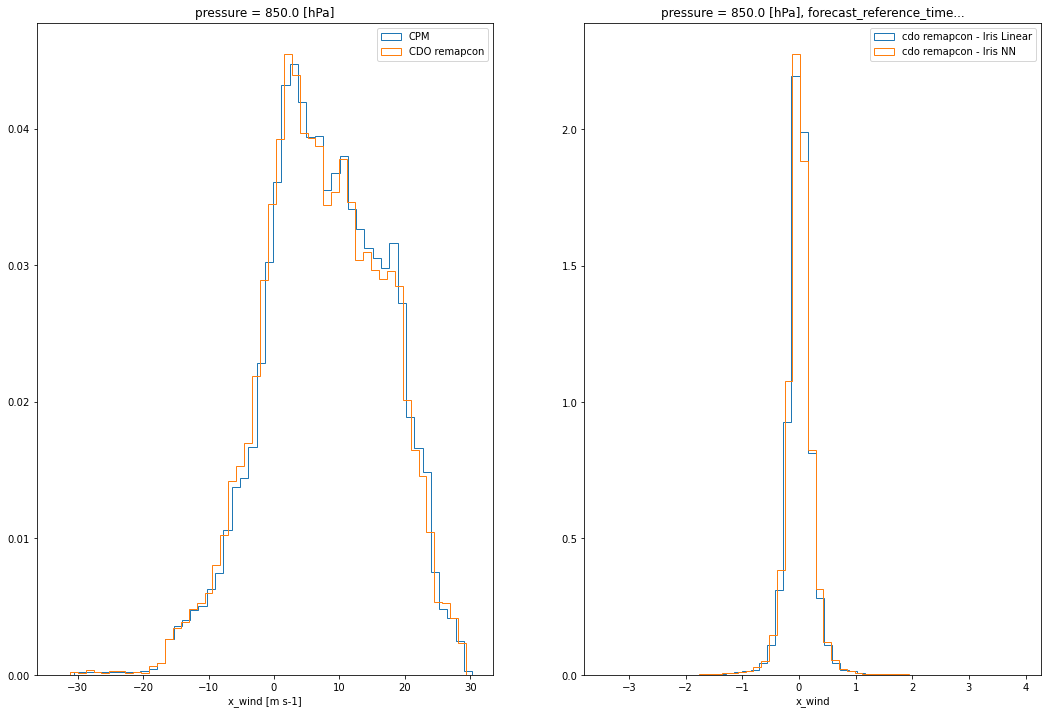

In [19]:
fig, axd = plt.subplot_mosaic([["cpm vs cdo", "cdo vs iris diff"]], figsize=(18, 12))

bins = 50
alpha=1

ax=axd["cpm vs cdo"]
ds_cpm["x_wind"].isel(pressure=1).plot(ax=ax, bins=bins, label="CPM", alpha=alpha, density=True, histtype="step")
ds_gcmed["x_wind"].isel(pressure=1).plot(ax=ax, bins=bins, label="CDO remapcon", alpha=alpha, density=True, histtype="step")
ax.legend()


ax=axd["cdo vs iris diff"]
(ds_gcmed["x_wind"]-xwind_lin_gcmed_da).isel(pressure=1).plot(ax=ax, bins=bins, label="cdo remapcon - Iris Linear", alpha=alpha, density=True, histtype="step")
(ds_gcmed["x_wind"]-xwind_nn_gcmed_da).isel(pressure=1).plot(ax=ax, bins=bins, label="cdo remapcon - Iris NN", alpha=alpha, density=True, histtype="step")

ax.legend()

plt.show()

In [100]:
xwind_gcmed["x_wind"].to_iris().coord('projection_y_coordinate').coord_system

In [89]:
xwind_lin_gcmed_da.latitude_bounds

AttributeError: 'DataArray' object has no attribute 'latitude_bounds'

In [34]:
xwind_cube = iris.load_cube(xwind_cpm_path)

In [45]:
xwind_cube.coord_system() == iris.coord_systems.RotatedGeogCS(37.5, 177.5, ellipsoid=iris.coord_systems.GeogCS(6371228.0))

False

In [ ]:
i